# Grafos sequenciais

A ideia aqui é criar dois nós sequenciais.
Para esta tarefa iremos pedir para uma LLM discutir sobre algum tópico e 
o segundo nó irá verificar qual argumento venceu

# Criando estrutura do grafo

In [19]:
from langchain_groq import ChatGroq
from typing import TypedDict
from langgraph.graph import StateGraph


class State(TypedDict):
    model: ChatGroq
    response_first_node: str
    response_second_node: str
    topic: str

graph_builder = StateGraph(State)

# Criando nós

### Primeiro nó

In [20]:
PRIMEIRO_NODE_PROMPT = """
Você irá receber um tópico e deverá argumentar as duas defesas do tópico dado

------
Tópico
------

{topic}
"""

In [21]:
def primeiro_node(state: State) -> State:
    model = state["model"]
    topic = state["topic"]
    prompt = PRIMEIRO_NODE_PROMPT.format(topic=topic)

    response_llm = model.invoke(prompt)
    return {
        "response_first_node": response_llm
    }
    
     

### Segundo nó

In [22]:
SEGUNDO_NODE_PROMPT = """
Você irá receber um argumento a respeito de um tópico,
e deverá decidir qual foi a melhor defesa a respeito do tópico

Tópico: {topic}
Argumento: {argument}
"""

In [23]:
def segundo_node(state: State) -> State:
    topic = state["topic"]
    model = state["model"]
    response_primeiro_node = state["response_first_node"]
    prompt = SEGUNDO_NODE_PROMPT.format(topic=topic, argument=response_primeiro_node)
    response = model.invoke(prompt)
    return {
        "response_second_node": response
    }

# Criando estrutura do grafo

In [24]:
from langgraph.graph import START, END

# Adição de nós
graph_builder.add_node("primeiro_node", primeiro_node)
graph_builder.add_node("segundo_node", segundo_node)

# Adição de edges
graph_builder.add_edge(START, "primeiro_node")
graph_builder.add_edge("primeiro_node", "segundo_node")
graph_builder.add_edge("segundo_node", END)

graph_compiled = graph_builder.compile()

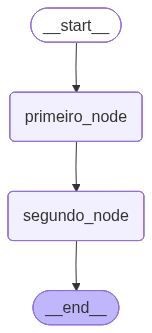

In [25]:
from IPython.display import display, Image

display(Image(graph_compiled.get_graph().draw_mermaid_png()))

# Rodando grafo

In [15]:
model = ChatGroq(model="openai/gpt-oss-120b", temperature=0, max_tokens=3000)

In [26]:
state = {
    "model": model,
    "topic": "Alain Prost vs Ayrton Senna",
    "response_first_node": "",
    "response_second_node": ""
}

response_final = graph_compiled.invoke(state)

In [29]:
# Primeira resposta

print(response_final["response_first_node"].content)

**Alain Prost vs Ayrton Senna – Defesas de Cada Lado**

---

## 1️⃣ Defesa de Alain Prost – “O Professor”

| **Argumento** | **Detalhes e Evidências** |
|---|---|
| **Consistência e Inteligência Estratégica** | - Campeão mundial em 1985, 1986, 1989 e 1993 (4 títulos). <br> - Maior número de pontos em temporadas completas (ex.: 1993: 112 pts, recorde da época). <br> - Conhecido por “pilotar a corrida”, economizando pneus, combustível e escolhendo o momento certo para atacar. |
| **Taxa de Pontos por Corrida** | - Média de pontos por corrida superior a 6,5 ao longo da carreira (considerando o sistema de pontuação da época). <br> - Em 1985, 13 pódios em 16 corridas (81 % de presença no pódio). |
| **Versatilidade em Diferentes Máquinas** | - Venceu com McLaren, Renault, Ferrari e Williams, demonstrando capacidade de adaptar-se a diferentes chassis, motores e filosofias técnicas. <br> - Primeiro piloto a vencer com três fabricantes diferentes. |
| **Domínio Técnico e Desenvolvimento** | - 

In [30]:
# Segunda resposta

print(response_final["response_second_node"].content)

**Análise das duas defesas**

| Critério | Defesa de Alain Prost | Defesa de Ayrton Senna |
|----------|----------------------|------------------------|
| **Clareza e estrutura** | Apresenta uma tabela bem organizada, com tópicos claros (consistência, taxa de pontos, versatilidade, etc.). Cada argumento é acompanhado de evidências numéricas e exemplos concretos. | Também usa tabela, mas mistura aspectos de performance com elementos de legado “humanitário”. A estrutura é boa, porém menos focada em métricas puras de desempenho. |
| **Uso de dados objetivos** | Usa números de campeonatos, vitórias, poles, média de pontos por corrida, recordes de pontuação e exemplos de desenvolvimento técnico. | Usa números de poles, vitórias, desempenho em chuva e em Mônaco, mas inclui mais argumentos qualitativos (carisma, inspiração, legado social). |
| **Argumentação persuasiva** | Concentra‑se em como a inteligência estratégica e a capacidade de adaptar‑se a diferentes carros transformam Prost no “pi